In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!wandb login 9676e3cc95066e4865586082971f2653245f09b4

Appending key for api.wandb.ai to your netrc file: /Users/guydavidson/.netrc
Successfully logged in to Weights & Biases!


In [3]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.special import factorial

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import path as mpath
import matplotlib.gridspec as gridspec

import pickle
import tabulate
import wandb
from collections import namedtuple

import meta_learning_data_analysis as analysis
import meta_learning_analysis_plots as plots

In [4]:
np.set_printoptions(linewidth=160)
# Avoid escaping any latex characters
tabulate.LATEX_ESCAPE_RULES = {}

MIN_FONT_SIZE = 14
LABELS_FONT_SIZE = 20
TITLE_FONT_SIZE = 24

matplotlib.rcParams.update({'font.size': MIN_FONT_SIZE})
FONT_DICT = dict(fontsize=LABELS_FONT_SIZE) 
TITLE_FONT_DICT = dict(fontsize=TITLE_FONT_SIZE)

PER_PLOT_WIDTH = 6

QUERY_ORDINAL_POSITION_COMORLAP= 'cool'
NUM_TIMES_TRAINED_COLORMAP = 'copper'

In [5]:
cache = analysis.refresh_cache()
print(cache.keys())

# query_mod_replications = cache['query_mod_replications']
# control_analyses = cache['control_analyses']
six_replications_updated_analyses = cache['six_replications_updated_analyses']
# control_updated_analyses = cache['updated_control_analyses']
# query_mod_updated_analyses = cache['query_mod_updated_analyses']

# MAML
maml_analyses = cache['maml_analyses']
maml_meta_test_analyses = cache['maml_meta_test_analyses']
balanced_batches_analyses = cache['balanced_batches_analyses']

# Simultaneous
simultaneous_training_analyses = cache['simultaneous_training_analyses']

dict_keys(['six_replications_analyses', 'control_analyses', 'query_mod_replications', 'six_replications_updated_analyses', 'updated_control_analyses', 'query_mod_updated_analyses', 'forgetting_curves_raw_data', 'preliminary_maml_analyses', 'baseline_maml_comparison_analyses', 'maml_analyses', 'maml_alpha_0_analyses', 'maml_meta_test_analyses', 'balanced_batches_analyses', 'baseline_total_curve_analyses', 'control_total_curve_analyses', 'query_mod_total_curve_analyses', 'simultaneous_training_analyses', 'per_task_simultaneous_training_analyses'])


-----

# Basic plots for regular data, and MAML-related conditions



log(y) = -1.642 log(x) + 11.54
Figure:

\begin{figure}[!htb]
% \vspace{-0.225in}
\centering
\includegraphics[width=\linewidth]{ch-results/figures/nips/response_maml_panel.pdf}
\caption{ {\bf FIGURE TITLE.} FIGURE DESCRIPTION.}
\label{fig:results-nips-response-maml-panel}
% \vspace{-0.2in}
\end{figure}


 Wrapfigure:

\begin{wrapfigure}{r}{0.5\linewidth}
\vspace{-.3in}
\begin{spacing}{1.0}
\centering
\includegraphics[width=0.95\linewidth]{ch-results/figures/nips/response_maml_panel.pdf}
\caption{ {\bf FIGURE TITLE.} FIGURE DESCRIPTION.}
\label{fig:results-nips-response-maml-panel}
\end{spacing}
% \vspace{-.25in}
\end{wrapfigure}



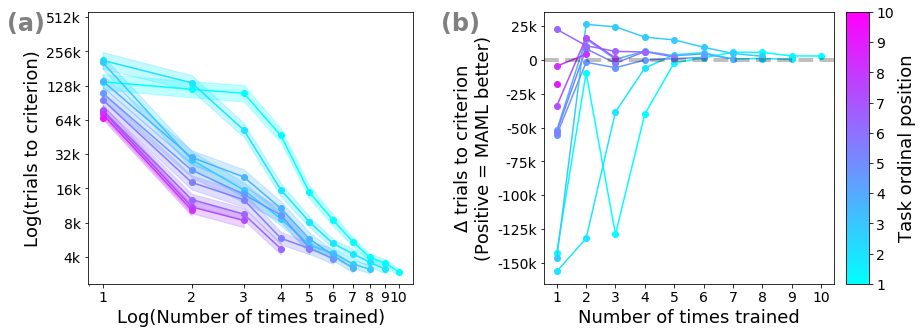

In [7]:
NROWS = 1
NCOLS = 2
COL_WIDTH = 6
ROW_HEIGHT = 5 
WIDTH_SPACING = 2
HEIGHT_SPACING = 0

title_font_dict = TITLE_FONT_DICT.copy()
title_font_dict['pad'] = 10

multi_plot_font_dict = FONT_DICT.copy()
multi_plot_font_dict['fontsize'] = 18
    
figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

replication_n = np.array((10, 10, 10, 30))
LOG_PLOT_YLIM = (7.75, 13.25)

comparison_level = 0

replication_n = np.array((10, 10, 10, 30))
sem_n = replication_n * 2

axes = (plt.subplot(NROWS, NCOLS, 1), None) # plt.subplot(NROWS, NCOLS, NCOLS + 1))
plots.plot_processed_results_all_dimensions(maml_meta_test_analyses, data_index=1, 
                                            title='', num_times_trained_title='',
                                            ylim=LOG_PLOT_YLIM, log_x=True, log_y=True, sem_n=sem_n, shade_error=True,
                                            font_dict=multi_plot_font_dict, times_trained_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                            tasks_trained_colormap=NUM_TIMES_TRAINED_COLORMAP,
                                            dimension_names=('',), dimension_indices=(3,),
                                            num_tasks_trained_highlight_first_time='highlight', add_colorbars=False,
                                            title_font_dict=TITLE_FONT_DICT, external_axes=axes,
                                            plot_regression='print')

axes = (plt.subplot(NROWS, NCOLS, 2), None) # plt.subplot(NROWS, NCOLS, NCOLS + 2))

plots.combined_comparison_plots(balanced_batches_analyses, {1: maml_meta_test_analyses}, 
                            '',
                            comparison_level, comparison_func=np.subtract,
                            font_dict=multi_plot_font_dict, comparison_first=True, 
                            data_index=0, 
                            log_x=False, log_y=False, shade_error=False,
                            title_font_dict=TITLE_FONT_DICT,
                            times_trained_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                            tasks_trained_colormap=NUM_TIMES_TRAINED_COLORMAP,
                            plot_y_label='$\Delta$ trials to criterion\n(Positive = MAML better)',
                            y_custom_tick_labels=[f'{int(x)}{x != 0 and "k" or ""}' for x in np.arange(-7, 2) * 25],
                            external_axes=axes, 
                            replication_levels=(1,), custom_titles=('',))

TEXT_POSITIONS = [(0.045, 0.83), (0.475, 0.83)]

subfigure_text_font_dict = FONT_DICT.copy()
subfigure_text_font_dict['fontsize'] += 4
subfigure_text_font_dict['color'] = '#808080'
subfigure_text_font_dict['weight'] = 'bold'

for i in range(len(TEXT_POSITIONS)):
    pos = TEXT_POSITIONS[i]
    plt.text(pos[0], pos[1], f'({chr(97 + i)})', 
             subfigure_text_font_dict, transform=figure.transFigure)

plots.save('nips/response_maml_panel.pdf')

log(y) = -1.642 log(x) + 11.54
Figure:

\begin{figure}[!htb]
% \vspace{-0.225in}
\centering
\includegraphics[width=\linewidth]{ch-results/figures/nips/response_combined_panel.pdf}
\caption{ {\bf FIGURE TITLE.} FIGURE DESCRIPTION.}
\label{fig:results-nips-response-combined-panel}
% \vspace{-0.2in}
\end{figure}


 Wrapfigure:

\begin{wrapfigure}{r}{0.5\linewidth}
\vspace{-.3in}
\begin{spacing}{1.0}
\centering
\includegraphics[width=0.95\linewidth]{ch-results/figures/nips/response_combined_panel.pdf}
\caption{ {\bf FIGURE TITLE.} FIGURE DESCRIPTION.}
\label{fig:results-nips-response-combined-panel}
\end{spacing}
% \vspace{-.25in}
\end{wrapfigure}



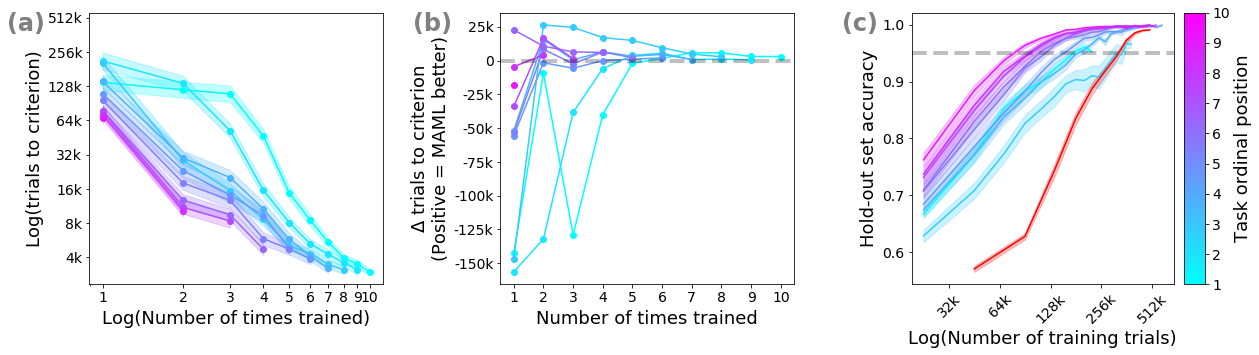

In [17]:
NROWS = 1
NCOLS = 3
COL_WIDTH = 6
ROW_HEIGHT = 5 
WIDTH_SPACING = 2
HEIGHT_SPACING = 0

title_font_dict = TITLE_FONT_DICT.copy()
title_font_dict['pad'] = 10

multi_plot_font_dict = FONT_DICT.copy()
multi_plot_font_dict['fontsize'] = 18
    
figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

replication_n = np.array((10, 10, 10, 30))
LOG_PLOT_YLIM = (7.75, 13.25)

comparison_level = 0

replication_n = np.array((10, 10, 10, 30))
sem_n = replication_n * 2

###### First panel -- raw MAML results

axes = (plt.subplot(NROWS, NCOLS, 1), None) # plt.subplot(NROWS, NCOLS, NCOLS + 1))
plots.plot_processed_results_all_dimensions(maml_meta_test_analyses, data_index=1, 
                                            title='', num_times_trained_title='',
                                            ylim=LOG_PLOT_YLIM, log_x=True, log_y=True, sem_n=sem_n, shade_error=True,
                                            font_dict=multi_plot_font_dict, times_trained_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                            tasks_trained_colormap=NUM_TIMES_TRAINED_COLORMAP,
                                            dimension_names=('',), dimension_indices=(3,),
                                            num_tasks_trained_highlight_first_time='highlight', add_colorbars=False,
                                            title_font_dict=TITLE_FONT_DICT, external_axes=axes,
                                            plot_regression='print')


###### Second panel -- MAML comparison

axes = (plt.subplot(NROWS, NCOLS, 2), None) # plt.subplot(NROWS, NCOLS, NCOLS + 2))

plots.combined_comparison_plots(balanced_batches_analyses, {1: maml_meta_test_analyses}, 
                            '',
                            comparison_level, comparison_func=np.subtract,
                            font_dict=multi_plot_font_dict, comparison_first=True, 
                            data_index=0, 
                            log_x=False, log_y=False, shade_error=False,
                            title_font_dict=TITLE_FONT_DICT,
                            times_trained_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                            tasks_trained_colormap=NUM_TIMES_TRAINED_COLORMAP,
                            plot_y_label='$\Delta$ trials to criterion\n(Positive = MAML better)',
                            y_custom_tick_labels=[f'{int(x)}{x != 0 and "k" or ""}' for x in np.arange(-7, 2) * 25],
                            external_axes=axes, add_colorbars=False,
                            replication_levels=(1,), custom_titles=('',))

###### Third panel -- simultaneous training

dimension_index = 1
axes = (plt.subplot(NROWS, NCOLS, 3), None)

plots.both_raw_accuracy_plots(six_replications_updated_analyses, '', dimension_index=dimension_index,
                              shade_error=True, font_dict=multi_plot_font_dict, log_x=True,
                              new_task_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                              first_task_colormap=NUM_TIMES_TRAINED_COLORMAP, title_font_dict=title_font_dict,
                              y_labels=('Hold-out set accuracy', 'Hold-out set accuracy'),
                              hline_y=0.95, first_task_title='', new_task_title='', add_colorbars=True,
                              external_axes=axes, plot_consecutive=False)

# add the simultaneous training plots

TRIALS_PER_EPOCH = 45000

simultaneous_y = simultaneous_training_analyses[dimension_index].mean
simultaneous_sem = simultaneous_training_analyses[dimension_index].sem

simultaneous_length = simultaneous_y.shape[0]
simultaneous_x = np.arange(1, simultaneous_length + 1) * TRIALS_PER_EPOCH

for ax in axes:
    if ax is not None:
        ax.plot(simultaneous_x, simultaneous_y, color='red')
        ax.fill_between(simultaneous_x, 
                        simultaneous_y - simultaneous_sem, 
                        simultaneous_y + simultaneous_sem,
                        color='red', alpha=0.25)

###### Laying in the text

TEXT_POSITIONS = [(0.068, 0.83), (0.35, 0.83), (0.648, 0.83) ]

subfigure_text_font_dict = FONT_DICT.copy()
subfigure_text_font_dict['fontsize'] += 4
subfigure_text_font_dict['color'] = '#808080'
subfigure_text_font_dict['weight'] = 'bold'

for i in range(len(TEXT_POSITIONS)):
    pos = TEXT_POSITIONS[i]
    plt.text(pos[0], pos[1], f'({chr(97 + i)})', 
             subfigure_text_font_dict, transform=figure.transFigure)

plots.save('nips/response_combined_panel.pdf')

## Examples to criterion

In [ ]:
NROWS = 2
NCOLS = 4
COL_WIDTH = 6
ROW_HEIGHT = 5 
WIDTH_SPACING = 2
HEIGHT_SPACING = 0

title_font_dict = TITLE_FONT_DICT.copy()
title_font_dict['pad'] = 10

multi_plot_font_dict = FONT_DICT.copy()
multi_plot_font_dict['fontsize'] = 18
    
figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
plt.subplots_adjust(hspace=0.4, wspace=0.35)

replication_n = np.array((10, 10, 10, 30))
LOG_PLOT_YLIM = (7.75, 13.25)

for index, (data, sem_n, title) in enumerate(zip((six_replications_updated_analyses, balanced_batches_analyses,
                                                 maml_analyses, maml_meta_test_analyses),
                                                 (replication_n * 6, replication_n * 3,
                                                  replication_n * 3, replication_n * 2),
                                                 ('Baseline', 'Balanced batches',
                                                  'MAML', 'MAML (meta-test)'))):
    axes = (plt.subplot(NROWS, NCOLS, index + 1), plt.subplot(NROWS, NCOLS, NCOLS + index + 1))
    plots.plot_processed_results_all_dimensions(data, data_index=1, 
                                                title='', num_times_trained_title=title,
                                                ylim=LOG_PLOT_YLIM, log_x=True, log_y=True, sem_n=sem_n, shade_error=True,
                                                font_dict=multi_plot_font_dict, times_trained_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                                tasks_trained_colormap=NUM_TIMES_TRAINED_COLORMAP,
                                                dimension_names=('',), dimension_indices=(3,),
                                                num_tasks_trained_highlight_first_time='highlight', add_colorbars=False,
                                                title_font_dict=TITLE_FONT_DICT, external_axes=axes,
                                                plot_regression='print')



plt.show()

-----

## Playing around with difference plots
Like what we did for the heterogeneous dimensions condition. Subtracting the baseline from each of the three other conditions above.

### First case -- subtracting in the raw example space

In [ ]:
NROWS = 2
NCOLS = 3
COL_WIDTH = 6
ROW_HEIGHT = 5 
WIDTH_SPACING = 2
HEIGHT_SPACING = 0

title_font_dict = TITLE_FONT_DICT.copy()
title_font_dict['pad'] = 10

multi_plot_font_dict = FONT_DICT.copy()
multi_plot_font_dict['fontsize'] = 18
    
figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
plt.subplots_adjust(hspace=0.4, wspace=0.7)

replication_n = np.array((10, 10, 10, 30))
LOG_PLOT_YLIM = (7.75, 13.25)

comparison_level = 0

for index, (data, sem_n, title) in enumerate(zip((six_replications_updated_analyses,
                                                 maml_analyses, maml_meta_test_analyses),
                                                 (replication_n * 6,
                                                  replication_n * 3, replication_n * 2),
                                                 ('Baseline',
                                                  'MAML', 'MAML (meta-test)'))):
    axes = (plt.subplot(NROWS, NCOLS, index + 1), plt.subplot(NROWS, NCOLS, NCOLS + index + 1))

    plots.combined_comparison_plots(balanced_batches_analyses, {1: data}, 
                                '',
                                comparison_level, comparison_func=np.subtract,
                                font_dict=multi_plot_font_dict, comparison_first=True, 
                                data_index=0, 
                                log_x=False, log_y=False, shade_error=False,
                                title_font_dict=TITLE_FONT_DICT,
                                times_trained_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                tasks_trained_colormap=NUM_TIMES_TRAINED_COLORMAP,
                                plot_y_label='$\Delta$ trials to criterion\n(Positive = MAML better)',
                                # y_custom_tick_labels=[None, '-50k', '0'] + [f'{(i+1) * 50}k' for i in range(4)],
                                external_axes=axes, 
                                replication_levels=(1,), custom_titles=(title,))

### Second case -- dividing in the raw trials space

In [ ]:
NROWS = 2
NCOLS = 3
COL_WIDTH = 6
ROW_HEIGHT = 5 
WIDTH_SPACING = 2
HEIGHT_SPACING = 0

title_font_dict = TITLE_FONT_DICT.copy()
title_font_dict['pad'] = 10

multi_plot_font_dict = FONT_DICT.copy()
multi_plot_font_dict['fontsize'] = 18
    
figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
plt.subplots_adjust(hspace=0.4, wspace=0.6)

replication_n = np.array((10, 10, 10, 30))
LOG_PLOT_YLIM = (7.75, 13.25)

comparison_level = 0

for index, (data, sem_n, title) in enumerate(zip((six_replications_updated_analyses,
                                                 maml_analyses, maml_meta_test_analyses),
                                                 (replication_n * 6,
                                                  replication_n * 3, replication_n * 2),
                                                 ('Baseline',
                                                  'MAML', 'MAML (meta-test)'))):
    axes = (plt.subplot(NROWS, NCOLS, index + 1), plt.subplot(NROWS, NCOLS, NCOLS + index + 1))

    plots.combined_comparison_plots(balanced_batches_analyses, {1: data},
                                '',
                                comparison_level, comparison_func=np.divide,
                                font_dict=multi_plot_font_dict, comparison_first=True, 
                                data_index=0, 
                                log_x=False, log_y=False, shade_error=False,
                                title_font_dict=TITLE_FONT_DICT,
                                times_trained_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                tasks_trained_colormap=NUM_TIMES_TRAINED_COLORMAP,
                                plot_y_label='Ratio trials to criterion',
                                # y_custom_tick_labels=[None, '-50k', '0'] + [f'{(i+1) * 50}k' for i in range(4)],
                                external_axes=axes, 
                                replication_levels=(1,), custom_titles=(title,))

### Second case -- division in the raw trials space -- flipped

In [ ]:
NROWS = 2
NCOLS = 3
COL_WIDTH = 6
ROW_HEIGHT = 5 
WIDTH_SPACING = 2
HEIGHT_SPACING = 0

title_font_dict = TITLE_FONT_DICT.copy()
title_font_dict['pad'] = 10

multi_plot_font_dict = FONT_DICT.copy()
multi_plot_font_dict['fontsize'] = 18
    
figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
plt.subplots_adjust(hspace=0.4, wspace=0.6)

replication_n = np.array((10, 10, 10, 30))
LOG_PLOT_YLIM = (7.75, 13.25)

comparison_level = 0

for index, (data, sem_n, title) in enumerate(zip((six_replications_updated_analyses,
                                                 maml_analyses, maml_meta_test_analyses),
                                                 (replication_n * 6,
                                                  replication_n * 3, replication_n * 2),
                                                 ('Baseline',
                                                  'MAML', 'MAML (meta-test)'))):
    axes = (plt.subplot(NROWS, NCOLS, index + 1), plt.subplot(NROWS, NCOLS, NCOLS + index + 1))

    plots.combined_comparison_plots(balanced_batches_analyses, {1: data}, 
                                '',
                                comparison_level, comparison_func=np.divide,
                                font_dict=multi_plot_font_dict, comparison_first=False, 
                                data_index=0, 
                                log_x=False, log_y=False, shade_error=False,
                                title_font_dict=TITLE_FONT_DICT,
                                times_trained_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                tasks_trained_colormap=NUM_TIMES_TRAINED_COLORMAP,
                                plot_y_label='Ratio trials to criterion',
                                # y_custom_tick_labels=[None, '-50k', '0'] + [f'{(i+1) * 50}k' for i in range(4)],
                                external_axes=axes, 
                                replication_levels=(1,), custom_titles=(title,))

### Third case - substracting in log space

In [ ]:
NROWS = 2
NCOLS = 3
COL_WIDTH = 6
ROW_HEIGHT = 5 
WIDTH_SPACING = 2
HEIGHT_SPACING = 0

title_font_dict = TITLE_FONT_DICT.copy()
title_font_dict['pad'] = 10

multi_plot_font_dict = FONT_DICT.copy()
multi_plot_font_dict['fontsize'] = 18
    
figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
plt.subplots_adjust(hspace=0.4, wspace=0.6)

replication_n = np.array((10, 10, 10, 30))
LOG_PLOT_YLIM = (7.75, 13.25)

comparison_level = 0

for index, (data, sem_n, title) in enumerate(zip((six_replications_updated_analyses,
                                                 maml_analyses, maml_meta_test_analyses),
                                                 (replication_n * 6,
                                                  replication_n * 3, replication_n * 2),
                                                 ('Baseline',
                                                  'MAML', 'MAML (meta-test)'))):
    axes = (plt.subplot(NROWS, NCOLS, index + 1), plt.subplot(NROWS, NCOLS, NCOLS + index + 1))

    plots.combined_comparison_plots(balanced_batches_analyses, {1: data}, 
                                '',
                                comparison_level, comparison_func=np.subtract,
                                font_dict=multi_plot_font_dict, comparison_first=True, 
                                data_index=1, 
                                log_x=False, log_y=False, shade_error=False,
                                title_font_dict=TITLE_FONT_DICT,
                                times_trained_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                tasks_trained_colormap=NUM_TIMES_TRAINED_COLORMAP,
                                plot_y_label='$\Delta$ trials to criterion',
                                # y_custom_tick_labels=[None, '-50k', '0'] + [f'{(i+1) * 50}k' for i in range(4)],
                                external_axes=axes, 
                                replication_levels=(1,), custom_titles=(title,))

### Fourth case - dividing in log space

In [ ]:
NROWS = 2
NCOLS = 3
COL_WIDTH = 6
ROW_HEIGHT = 5 
WIDTH_SPACING = 2
HEIGHT_SPACING = 0

title_font_dict = TITLE_FONT_DICT.copy()
title_font_dict['pad'] = 10

multi_plot_font_dict = FONT_DICT.copy()
multi_plot_font_dict['fontsize'] = 18
    
figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
plt.subplots_adjust(hspace=0.4, wspace=0.6)

replication_n = np.array((10, 10, 10, 30))
LOG_PLOT_YLIM = (7.75, 13.25)

comparison_level = 0

for index, (data, sem_n, title) in enumerate(zip((six_replications_updated_analyses,
                                                 maml_analyses, maml_meta_test_analyses),
                                                 (replication_n * 6,
                                                  replication_n * 3, replication_n * 2),
                                                 ('Baseline',
                                                  'MAML', 'MAML (meta-test)'))):
    axes = (plt.subplot(NROWS, NCOLS, index + 1), plt.subplot(NROWS, NCOLS, NCOLS + index + 1))

    plots.combined_comparison_plots(balanced_batches_analyses, {1: data}, 
                                '',
                                comparison_level, comparison_func=np.divide,
                                font_dict=multi_plot_font_dict, comparison_first=True, 
                                data_index=1, 
                                log_x=False, log_y=False, shade_error=False,
                                title_font_dict=TITLE_FONT_DICT,
                                times_trained_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                tasks_trained_colormap=NUM_TIMES_TRAINED_COLORMAP,
                                plot_y_label='Ratio trials to criterion',
                                # y_custom_tick_labels=[None, '-50k', '0'] + [f'{(i+1) * 50}k' for i in range(4)],
                                external_axes=axes, 
                                replication_levels=(1,), custom_titles=(title,))

-------

## Accuracy after 22.5k examples

In [ ]:
NROWS = 2
NCOLS = 4
COL_WIDTH = 6
ROW_HEIGHT = 5 
WIDTH_SPACING = 2
HEIGHT_SPACING = 0

title_font_dict = TITLE_FONT_DICT.copy()
title_font_dict['pad'] = 10

multi_plot_font_dict = FONT_DICT.copy()
multi_plot_font_dict['fontsize'] = 18
    
figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
plt.subplots_adjust(hspace=0.4, wspace=0.35)

replication_n = np.array((10, 10, 10, 30))
ACCURACY_PLOT_YLIM = (0.5, 1.0)

for index, (data, sem_n, title) in enumerate(zip((six_replications_updated_analyses, balanced_batches_analyses,
                                                 maml_analyses, maml_meta_test_analyses),
                                                 (replication_n * 6, replication_n * 3,
                                                  replication_n * 3, replication_n * 2),
                                                 ('Baseline', 'Balanced batches',
                                                  'MAML', 'MAML (meta-test)'))):
    axes = (plt.subplot(NROWS, NCOLS, index + 1), plt.subplot(NROWS, NCOLS, NCOLS + index + 1))
    plots.plot_processed_results_all_dimensions(data, data_index=3, 
                                                title='', num_times_trained_title=title,
                                                ylim=ACCURACY_PLOT_YLIM, sem_n=sem_n, shade_error=True, plot_y_label='Accuracy\nafter 22.5k trials',
                                                font_dict=multi_plot_font_dict, times_trained_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                                tasks_trained_colormap=NUM_TIMES_TRAINED_COLORMAP,
                                                dimension_names=('',), dimension_indices=(3,),
                                                num_tasks_trained_highlight_first_time='highlight', add_colorbars=False,
                                                title_font_dict=TITLE_FONT_DICT, external_axes=axes,
                                                plot_regression='print')



plt.show()


----

Trying some sign tests

In [ ]:



diff = six_replications_updated_analyses.combined.log_examples.mean - maml_meta_test_analyses.combined.log_examples.mean

plt.imshow(diff, 'bwr')
plt.colorbar()